In [6]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import *
from keras.optimizers import *
from skimage.transform import resize
from skimage.io import imread,imshow,imsave
import keras.backend as k
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from IPython.display import FileLink
import cv2
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Dropout, BatchNormalization , Activation , Input,Conv2D,MaxPooling2D,Dense,Flatten
from keras.regularizers import l1,l2
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from keras.callbacks import Callback,ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
%matplotlib inline

In [19]:
os.listdir('X_Y_kvasir')

['desktop.ini', 'X.npy', 'Y.npy']

In [22]:
X=np.load('X_Y_kvasir/X.npy')

In [23]:
Y=np.load('X_Y_kvasir/Y.npy')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(X_train.shape , X_val.shape , X_test.shape)

(5760, 128, 128, 3) (1440, 128, 128, 3) (800, 128, 128, 3)


In [25]:
Y.shape

(8000, 8)

(<matplotlib.image.AxesImage at 0x195fed5a610>,
 array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32))

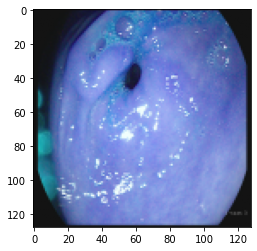

In [26]:
plt.imshow(X_train[18]),y_train[18]

In [27]:
BATCH_SIZE = 16
TRAIN_DIR = '/content/drive/MyDrive/dataset/kvasir-dataset-v2/kvasir-dataset-v2/'

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=10,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
val_datagen.fit(X_val)
test_datagen.fit(X_test)

In [28]:

def my_model(input_shape,n_classes):
  perior_model=tf.keras.applications.ResNet152V2(include_top=False, weights=None,input_shape=input_shape)
  input_tensor = Input(shape=input_shape)
  bn=BatchNormalization()(input_tensor)
  x=perior_model(bn)
  x=Conv2D(128,kernel_size=(1,1),activation='relu')(x)
  x=Flatten()(x)
  x=Dense(512,activation='relu')(x)
  output=Dense(n_classes,activation='softmax')(x)
  model=Model(input_tensor,output)

  return model

In [29]:
model=my_model((128,128,3),8)
model.compile(optimizer=Adam(lr=2e-5,decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000001960665C910>>

In [30]:
model_h5='model_weught.hdf5'.format()

In [31]:
checkpoint = ModelCheckpoint(model_h5, verbose=2, monitor='val_loss',save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, verbose=1, mode='min', min_delta=0.0001, cooldown=5, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss",  mode="min",   patience=12) 
callbacks_list = [reduceLROnPlat,early,checkpoint]

In [ ]:
result = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                   validation_data=(X_val,y_val),
                   steps_per_epoch=len(X_train) / BATCH_SIZE
                   ,epochs=50,
                  callbacks=callbacks_list)

Epoch 1/50
 44/360 [==>...........................] - ETA: 27:20 - loss: 2.2613 - accuracy: 0.1214

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'],label='loss')
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('log_loss')
plt.plot( np.argmin(model.history.history["val_loss"]), np.min(model.history.history["val_loss"]), marker="x", color="r", label="best model")

plt.legend()


In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['loss','val_loss'])
plt.show()

In [ ]:
predict=model.predict(X_test)
plt.imshow(X_test[500])
y500=predict[500]
target_names = ['normal-pylorus', 'normal-z-line', 'dyed-resection-margins', 'ulcerative-colitis', 'dyed-lifted-polyps', 'normal-cecum', 'esophagitis', 'polyps']
choosen=0
for i in range(len(y500)):
  if y500[choosen]<y500[i]:
    choosen=i
print(target_names[choosen]+'\n')

In [ ]:
x=np.arange(8)
plt.bar(x,y)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def decode(datum):
    return np.argmax(datum)

mybatchlabels = []
for i in range(len(X_test)):
  mybatchlabels.append(decode(y_test[i]))

y_pred = np.argmax(predict, axis=1)
print('Classification Report')
print(classification_report(mybatchlabels, y_pred, target_names=target_names))